<a href="https://colab.research.google.com/github/andigu/Coin-Simulation/blob/master/lenstronomy_modeling/TF/Lens_Modelling_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Aug 13 17:21:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install lenstronomy==1.8.2 cosmohammer schwimmbad dynesty corner > /dev/null
!pip install --upgrade tensorflow_addons PyYAML tensorflow_probability > /dev/null

In [159]:
!cp ./drive/MyDrive/tf_lenstronomy.py ./
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import jn_zeros
from scipy.optimize import curve_fit
import tensorflow_probability as tfp
from astropy.io import fits
import pandas as pd

from lenstronomy.Util.param_util import ellipticity2phi_q
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.Plots import lens_plot
from matplotlib import cm
from operator import itemgetter
from tf_lenstronomy import *
from lenstronomy.Util import simulation_util
import matplotlib as mpl
from lenstronomy.LensModel.lens_model import LensModel
from scipy.interpolate import griddata
from skimage.filters import median, rank
from skimage.morphology import disk
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import pandas as pd
EPL._prior[0] = tfd.Uniform(0.7, 3.0)
EPL._prior[1] = tfd.Uniform(1.5, 2.5)
EPL._prior[2] = tfd.TruncatedNormal(0, 0.1, -0.35, 0.35)
EPL._prior[3] = tfd.TruncatedNormal(0, 0.1, -0.35, 0.35)
Shear._prior[0] = tfd.TruncatedNormal(0, 0.01, -0.1, 0.1)
Shear._prior[1] = tfd.TruncatedNormal(0, 0.01, -0.1, 0.1)
SIE._prior[0] = tfd.Uniform(0.7, 3.0)
tfd = tfp.distributions
mpl.rcParams['image.cmap'] = 'gray_r'

In [160]:
def plot_figures(model, best_try, src_width=0.5, srcDeltaPix=0.01):
    ori = 0
    lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'])
    kwargs_lens, const, kwargs_source = model.param_to_dict(best_try)
    beta_x, beta_y = ImSim(model, 0.065, numPix).beta(best_try)
    beta_x, beta_y, values = beta_x[to_model].numpy(), beta_y[to_model].numpy(), observed_image[to_model]
    width_x, width_y = src_width, src_width
    src_cx, src_cy = None, None
    try:
        src_cx, src_cy = itemgetter('center_x', 'center_y')(kwargs_source[0])
    except:
        src_cx = (model.sourceLight[0].min_x+model.sourceLight[0].max_x)/2
        src_cy = (model.sourceLight[0].min_y+model.sourceLight[0].max_y)/2

    XX = np.arange(src_cx-width_x, src_cx+width_x,srcDeltaPix).astype(np.float32)
    YY = np.arange(src_cy-width_y, src_cy+width_y,srcDeltaPix).astype(np.float32)
    ZZ = griddata((beta_x, beta_y), values, (XX[None,:], YY[:,None]), method='linear', fill_value=0)
    source_reconstructed = median(ZZ, disk(2))
    src_integral = np.sum(source_reconstructed * srcDeltaPix**2)

    model2 = Model(model.lenses, model.lensLight, [PixelBased(tf.meshgrid(XX, YY), deltaPix=srcDeltaPix)])
    imSim2 = ImSim(model2, deltaPix=0.065, numPix=numPix)
    best_try2 = best_try[:8].numpy()
    best_try2 = np.append(best_try2, ZZ.flatten()).astype(np.float32)
    lensed_reconstructed = np.where(to_model, imSim2.simulate(best_try2), 0)
    lens_integral = np.sum(lensed_reconstructed * 0.065**2)
    total_mag = lens_integral/src_integral
    max_clip = np.percentile(observed_image, 99.9)

    fig, axes = plt.subplots(2, 4, figsize=(12.1,6))
    (ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = np.array(axes).flatten()
    meta = np.load(fname, allow_pickle=True).item()['meta']
    kwargs_lens, _, kwargs_source = model.param_to_dict(best_try)
    theta_E, gamma, e1, e2, cx, cy = itemgetter('theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y')(kwargs_lens[0])
    phi, q = ellipticity2phi_q(e1, e2)
    phi = -phi*180/np.pi
    Gamma1, Gamma2 = itemgetter('gamma1', 'gamma2')(kwargs_lens[1])
    gamma_strength = np.sqrt(Gamma1**2 + Gamma2**2)
    gamma_phi = np.arctan2(Gamma2, Gamma1)/2
    gamma_phi = -gamma_phi*180/np.pi
    
    fig.suptitle(x=0.5, y=1, ha='center', va='bottom', t=f'{meta["TARGNAME"]}', fontsize=18)
    # z_str = f'$z_d={z_string}$' if "-" not in z_string else f'$z_d={z_string.split("-")[0]} \\pm {z_string.split("-")[1]}$'
    #  
    
    fig.text(0, 0.5, ha='right', va='center', fontsize=11,
        s=f'''$\\theta_E={theta_E:.2f} \ \ \\gamma={gamma:.2f}$
            $q={q:.2f} \ \ \phi={(phi%180):.1f}^{{\circ}}$
            $q_{{light}}={meta["LIGHT_Q"]:.2f} \ \ \phi_{{light}}={(meta["LIGHT_PHI"])%180:.1f}^{{\circ}}$
            $\gamma_{{ext}}={gamma_strength:.2f} \ \ \phi_{{ext}}={(gamma_phi%180):.1f}^{{\circ}}$
            $\mu={total_mag:.1f}$
            ''')


    ax0.set_title('Observed')
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('left', size='5%', pad=0.065)
    original_lim = np.percentile(original, 97.5)
    imdata = ax0.imshow(original, vmin=0, vmax=original_lim, origin='lower', interpolation='bilinear', extent=[-scale*0.065,scale*0.065,-scale*0.065,scale*0.065])
    fig.colorbar(imdata, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position('left')
    scalebar = AnchoredSizeBar(ax0.transData,
                           1, '1"', 'lower left', 
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=0.007)
    ax0.add_artist(scalebar)
    L = 0.75
    ax0.arrow(scale*0.065-0.2,-scale*0.065+0.2, -L, 0, ec='black', fc='black', linewidth=0.8, head_width=0.15, head_length=0.15)
    ax0.arrow(scale*0.065-0.2,-scale*0.065+0.2,  0, L, ec='black', fc='black', linewidth=0.8, head_width=0.15, head_length=0.15)
    ax0.text(scale*0.065-0.2, -scale*0.065+0.4+L, s='N', color='black', ha='center')
    ax0.text(scale*0.065-0.4-L, -scale*0.065+0.2, s='E', color='black', ha='right', va='center')
    ax0.set_xticks([])
    ax0.set_yticks([])

    ax1.imshow(np.where(likelihood_mask, observed_image, 0), cmap='gray_r', interpolation='bilinear', origin='lower', vmin=0, vmax=max_clip)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Masked Features')

    ax2.imshow(np.where(likelihood_mask, lensed_reconstructed, 0), cmap='gray_r', interpolation='bilinear', origin='lower', vmin=0, vmax=max_clip)
    ax2.set_title('Reconstructed')
    ax2.set_xticks([])
    ax2.set_yticks([])

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.065)
    err_map = np.sqrt((img_noise)**2 + observed_image.clip(0,np.inf) / meta['EXPTIME'])
    err = (lensed_reconstructed-observed_image)/err_map
    err = np.where(likelihood_mask, err, 0)
    imdata = ax3.imshow(np.ma.masked_where(~likelihood_mask, err), cmap='coolwarm', vmin=-5, vmax=5, origin='lower', interpolation='bicubic')
    ax3.set_title('Residual')
    ax3.set_xticks([])
    ax3.set_yticks([])
    fig.colorbar(imdata, cax=cax, orientation='vertical', label=r'$(y_{model}-y_{obs})/\sigma$')

    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('left', size='5%', pad=0.065)
    imdata = ax4.imshow(subtracted, origin='lower', interpolation='bilinear', vmin=0, vmax=original_lim)
    fig.colorbar(imdata, cax=cax, orientation='vertical')
    cax.yaxis.set_ticks_position('left')
    ax4.set_title('Modelled lens light')
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    lens_plot.lens_model_plot(ax5, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, 
                            fast_caustic=False, numPix=numPix, deltaPix=0.065, with_convergence=False)
    ax5.imshow(np.where(likelihood_mask, observed_image, 0), origin='lower', extent=[-scale*0.065,scale*0.065,-scale*0.065,scale*0.065], vmin=0, vmax=max_clip)
    ax5.set_title('Lens Model', pad=-5)
    ax5.set_xticks([])
    ax5.set_yticks([])

    source_dim = len(source_reconstructed)//2
    lens_plot.lens_model_plot(ax6, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, 
                            fast_caustic=False, numPix=numPix, deltaPix=0.065, with_convergence=False)
    ax6.imshow(source_reconstructed.clip(0,np.inf), cmap='gray', origin='lower', 
            interpolation='bicubic', extent=[src_cx-width_x, src_cx+width_x, src_cy-width_y, src_cy+width_y])
    ax6.set_xlim(src_cx-width_x, src_cx+width_x)
    ax6.set_ylim(src_cy-width_y, src_cy+width_y)
    scalebar = AnchoredSizeBar(ax6.transData, 0.3, '0.3"', 'lower left',  pad=0.1, color='white', frameon=False, size_vertical=3e-3)
    ax6.add_artist(scalebar)
    ax6.set_title('Reconstructed source')
    ax6.axis('off')

    ret = ax7.hist(err[likelihood_mask].clip(-5,5), bins=15, density=True, fill=False)
    height, X = ret[0], (ret[1][1:]+ret[1][:-1])/2
    gaussian = lambda x, C, mu, sigma: C * np.exp(-(x-mu)**2/(2*sigma**2))
    popt, pcov = curve_fit(gaussian, X, height)

    ret = np.histogram(err[likelihood_mask].clip(-5,5), bins=25, density=True)
    height, X = ret[0], (ret[1][1:]+ret[1][:-1])/2
    X = np.linspace(-5,5, 150)
    ax7.plot(X, gaussian(X, *popt))
    ax7.set_yticks([])
    ax7.set_xlim(-5,5)
    ax7.text(0.95, 0.95, s=f'$\sigma={np.std(err[likelihood_mask], ddof=9):.2f}$', fontsize=15, ha='right', va='top', transform=ax7.transAxes)
    ax7.set_title('Normalized residuals')

    fig.subplots_adjust(wspace=0, hspace=0,left=0,bottom=0)
    fig.tight_layout()
    return fig

0.000383967603172091


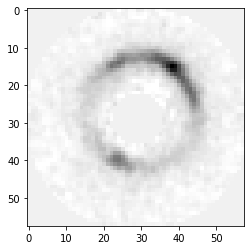

In [161]:
objid = 'test-J0029'
fname = f'{objid}.npy'
data = np.load(fname, allow_pickle=True).item()['data'][1:-1,1:-1,...]
scale = int(data.shape[0]/2)
dim = data.shape[0]
observed_image = data[...,0]
subtracted = data[...,2]
likelihood_mask = data[...,1].astype(np.bool)
original = data[...,0] + data[...,2]
img_noise = np.std(observed_image[:10,:10])
to_model = likelihood_mask & (observed_image >= 2*img_noise)
print(img_noise)
observed_image = np.where(likelihood_mask, observed_image, 0)
err_map = np.sqrt(img_noise**2 + np.clip(observed_image, 0, np.inf)/2400)
plt.imshow(observed_image, vmin=-3*img_noise)

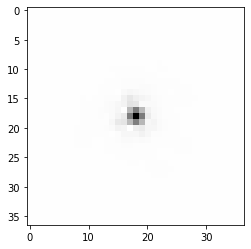

In [162]:
from lenstronomy.Util.kernel_util import *
from scipy import ndimage

ori = np.load(fname, allow_pickle=True).item()['meta']['ORI']
exp_time = np.load(fname, allow_pickle=True).item()['meta']['EXPTIME']
# kernel = fits.getdata('drive/MyDrive/f140w00.fits').astype(np.float32)
# kernel = kernel_pixelsize_change(kernel, fits.getheader('drive/MyDrive/f140w00.fits')['PIXSCALE'], 0.13/2).astype(np.float64)
# kernel = subgrid_kernel(fits.getdata('drive/MyDrive/f140w00.fits').astype(np.float32), 2, odd=True, num_iter=1000)
# kernel = fits.getdata('f555w00.fits')[8:-8,8:-8]
kernel = fits.getdata('f606w00.fits')[1:,1:]
kernel = subgrid_kernel(kernel.astype(np.float32), 2, odd=True, num_iter=100)[10:-10,10:-10]
kernel = ndimage.rotate(kernel, -ori, reshape=False)
kernel /= kernel.sum()
plt.imshow(kernel)
# plt.imshow(np.log10(kernel))

In [163]:
epl_model = Model([EPL(18), Shear()], [], [SersicEllipse()], 'EPL_MODEL')

from tqdm.auto import trange
numPix = len(observed_image)
err_map = tf.cast(tf.math.sqrt(img_noise**2 + np.abs(observed_image)/exp_time), tf.float32)
err_map = tf.where(likelihood_mask, err_map, 1e30)
observed_data = tfd.Independent(tfd.Normal(loc=observed_image.astype(np.float32), scale=err_map), reinterpreted_batch_ndims=2)
observed_image_reshape = observed_image[tf.newaxis,...]
img_size = tf.constant(tf.cast(tf.size(observed_image), tf.float32))

In [164]:
def minimize(model, start, num_iters=5000, use_lstsq=True, supersample=1):
    lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, num_iters, 1e-3, power=0.5, cycle=False)
    optimizer = tf.keras.optimizers.Adam(lr)
    best_score = np.inf
    best_try = None
    trial = tfp.util.TransformedVariable(initial_value=start, bijector=tfp.bijectors.Invert(model.bij))
    imSim = ImSim(model, 0.065, numPix, kernel=kernel, bs=len(start), supersample=supersample)
    trainable_variables = [trial.trainable_variables[0]]
    
    @tf.function
    def train_step(add_prior=False):
        with tf.GradientTape() as tape:
            pred = imSim.lstsq_simulate(trial, observed_image, err_map) if use_lstsq \
                    else imSim.simulate(trial)
            square_err = tf.reduce_sum((pred-observed_image_reshape)**2/err_map**2, axis=(1,2))/np.sum(likelihood_mask)
            loss = -tf.squeeze(observed_data.log_prob(pred)/np.sum(likelihood_mask))
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, square_err

    with trange(num_iters) as pbar:
        for i in pbar:
            loss, square_err = train_step(True)
            best = np.nanargmin(loss)
            current_s = np.nanmin(loss)
            if current_s < best_score:
                best_score = current_s
                best_try = trial[best]
            pbar.set_description(f'chisq {(square_err[best]):.4f} best {(best_score):.4f}')
            np.save(f'{model.name}.npy', best_try)

In [ ]:
np.random.seed(2)
tf.random.set_seed(2)
minimize(epl_model, epl_model.base_prior.sample(1000), use_lstsq=True, num_iters=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

([{'center_x': 0.05996622,
   'center_y': 0.011360258,
   'e1': -0.20989119,
   'e2': -0.07371858,
   'gamma': 2.6636596,
   'theta_E': 0.9482535},
  {'gamma1': -0.017395362, 'gamma2': 0.02052027}],
 [],
 [{'Ie': 3.8840656,
   'R_sersic': 0.15761171,
   'center_x': 0.14505094,
   'center_y': -0.14995807,
   'e1': -0.017538726,
   'e2': -0.1422568,
   'n_sersic': 0.8702761}])

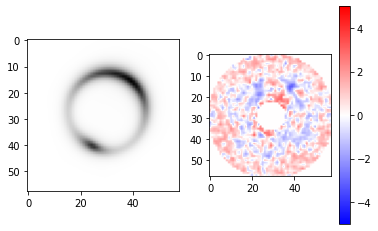

In [140]:
plt.subplot(121)
plt.imshow(ImSim(epl_model, 0.065, numPix, kernel=kernel).lstsq_simulate(np.load(epl_model.name + '.npy'), observed_image, err_map))
plt.subplot(122)
plt.imshow((ImSim(epl_model, 0.065, numPix, kernel=kernel).lstsq_simulate(np.load(epl_model.name + '.npy'), observed_image, err_map) - observed_image)/err_map, vmin=-5, vmax=5, cmap='bwr')
plt.colorbar()
epl_model.param_to_dict(np.load(epl_model.name + '.npy'))

In [141]:
# fig = plot_figures(epl_model, tf.convert_to_tensor(np.load(epl_model.name + '.npy')), 0.5, srcDeltaPix=0.005);
# fig.savefig(f'{objid}.png', bbox_inches='tight')

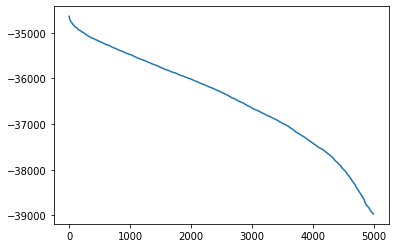

In [154]:
epl = EPL(18)
epl_model2 = Model([epl, Shear()], [], [SersicEllipse(), SersicEllipse()], 'EPL_MODEL')
best_try = np.load(epl_model.name + '.npy')
best_try = np.append(best_try, best_try[-7:]+np.random.normal(scale=0.05, size=7)).astype(np.float32)


imSim = ImSim(epl_model2, 0.065, numPix, kernel=kernel, bs=5000)
std = tf.convert_to_tensor([x.stddev() for x in epl_model2.base_prior.distributions])
delta = np.random.normal(size=(5000, len(best_try)), scale=0.5)
delta[:,-14:] = 0
start = epl_model2.bij.inverse(epl_model2.bij.forward(best_try) + delta)
probs = observed_data.log_prob(imSim.lstsq_simulate(start, observed_image, err_map))
start_master = start.numpy()[tf.argsort(probs, direction='DESCENDING')]
plt.plot(tf.sort(probs, direction='DESCENDING'))

In [155]:
from tqdm.auto import *
walker_ratio = 10
imSim = ImSim(epl_model2, 0.065, numPix, kernel=kernel, bs=len(best_try)*walker_ratio)

def tqdm_progress_bar_fn(num_steps):
    return iter(tqdm(range(num_steps), desc='', leave=True))

@tf.function
def target_log_prob(x):
    pred = imSim.lstsq_simulate(x, observed_image, err_map)
    return tf.squeeze(observed_data.log_prob(pred))

@tf.function
def run_chain():
    num_results = 1000
    num_burnin_steps = 1000
    start = tf.identity(start_master[:len(best_try)*walker_ratio])
    step_size = tf.ones(len(best_try))*1/3
    # step_size = tf.ones_like(start)*1/3
    mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob, 
                                                step_size=step_size, num_leapfrog_steps=3), 
                                                num_adaptation_steps=int(num_burnin_steps*0.8))
    mc_kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=mc_kernel,
    bijector=tfp.bijectors.Invert(epl_model2.bij))
    pbar = tfp.experimental.mcmc.ProgressBarReducer(num_results+num_burnin_steps-1, progress_bar_fn=tqdm_progress_bar_fn)
    mc_kernel = tfp.experimental.mcmc.WithReductions(mc_kernel, pbar)

    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=start,
        kernel=mc_kernel,)

In [156]:
samples, mc_results = run_chain()
accepted = mc_results.inner_results.inner_results.inner_results.is_accepted

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/1999 [00:00<?, ?it/s]

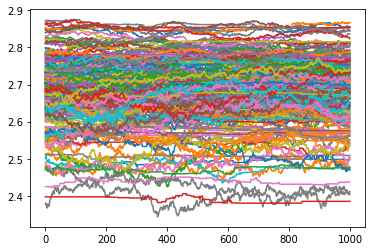

In [157]:
plt.plot(samples[:,:,1]);

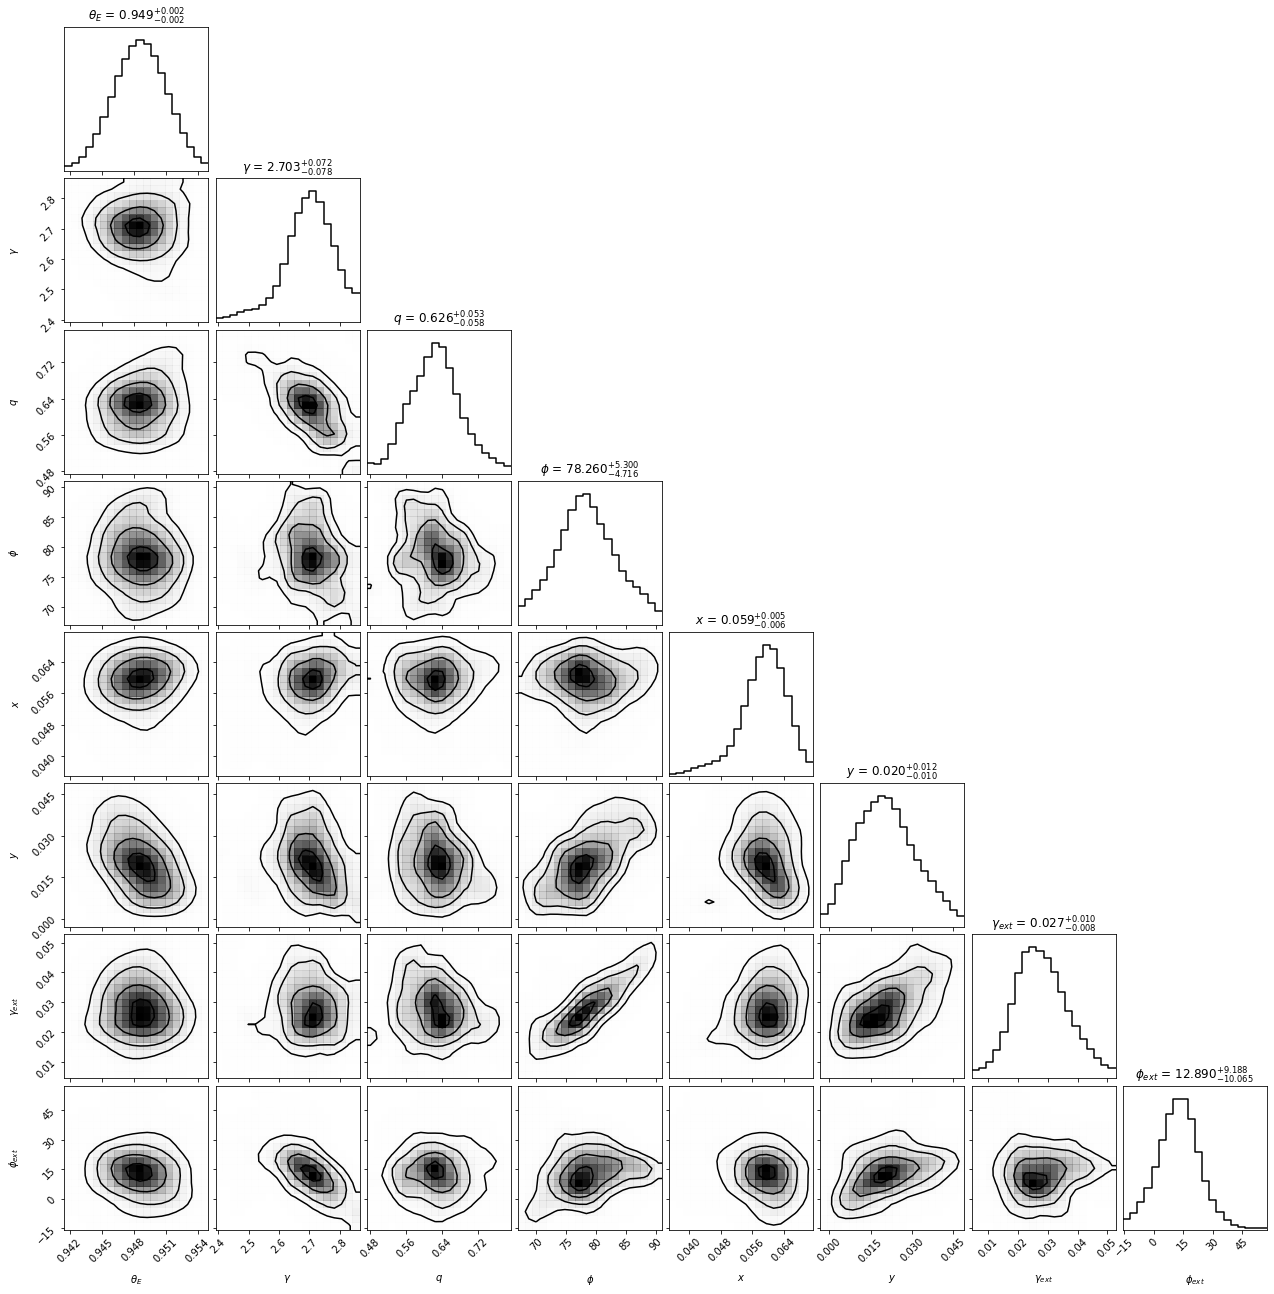

In [158]:
from corner import corner
phi, q = ellipticity2phi_q(samples[accepted][:,2].numpy(), samples[accepted][:,3].numpy())
acc = samples[accepted][:,:8].numpy()
acc[:,2] = q
acc[:,3] = (-phi*180/np.pi) % 180
acc[:,-2], acc[:,-1] = np.sqrt(acc[:,-1]**2 + acc[:,-2]**2), (-np.arctan2(acc[:,-2], acc[:,-1])/2 * 180/np.pi)

fig = corner(acc, show_titles=True, smooth=0.9, smooth1d=1, title_fmt='.3f', 
       verbose=True, range=[0.995 for _ in range(8)], plot_datapoints=False,
       labels=[r'$\theta_E$', r'$\gamma$', r'$q$', r'$\phi$', r'$x$', r'$y$', r'$\gamma_{ext}$', r'$\phi_{ext}$']);
fig.savefig('j1531-corner.png')

# Lenstronomy

In [ ]:
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar
shapeletSet = ShapeletSet()

kwargs_data_real = sim_util.data_configure_simple(numPix, 0.065, exp_time, img_noise)
data_real = ImageData(**kwargs_data_real)
kwargs_data_high_res = sim_util.data_configure_simple(numPix*9, 0.065/9, exp_time, img_noise)
data_high_res = ImageData(**kwargs_data_high_res)

data_real.update_data(observed_image)
shapelet_type = 'cartesian' # 'cartesian', 'polar', 'exponential'
psf = PSF(psf_type='PIXEL', kernel_point_source=kernel, pixel_size=0.065)

if shapelet_type == 'exponential':
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR_EXP'])
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=True)
    n_max_reconstruct = 8
    beta_reconstruct = 0.01
elif shapelet_type == 'polar':
    
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=False)
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR'])
    n_max_reconstruct = 20
    beta_reconstruct = 0.15
else:
    sourceLightModel_reconstruct = LightModel(['SHAPELETS'])
    shapeletSet_reconstruct = shapeletSet
    n_max_reconstruct = 12
    beta_reconstruct = 0.1
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
lensModel = LensModel(['EPL_NUMBA', 'SHEAR'])
imageModel = ImageLinearFit(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel_reconstruct)

kwargs_lens = sie_model.param_to_dict(best_try)[0]  # we use the same lens model to reconstruct the image
source_x, source_y = itemgetter('center_x', 'center_y')(sie_model.param_to_dict(best_try)[-1][0])
kwargs_source = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model
plt.subplot(121)
plt.imshow((lensed_reconstructed-observed_image)/err_map, cmap='bwr', vmin=-5,vmax=5)
import lenstronomy.Util.util as util

x_coords, y_coords = data_high_res.pixel_coordinates
source_reconstructed = shapeletSet_reconstruct.function(util.image2array(x_coords), 
                                                        util.image2array(y_coords), 
                                                        param, n_max_reconstruct, 
                                                        beta_reconstruct, center_x=source_x, center_y=source_y)
source_reconstructed_2d = util.array2image(source_reconstructed) * (0.065/9)**2
plt.subplot(122)
plt.imshow(source_reconstructed_2d)

In [ ]:
epl_model.param_to_dict(best_try)

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence
kwargs_data = {'image_data': observed_image,
               'background_rms': img_noise,
               'exposure_time': exp_time,
               'ra_at_xy_0': imSim.img_X.numpy().min(),  
               'dec_at_xy_0': imSim.img_Y.numpy().min(),
               'transform_pix2angle': np.eye(2)*0.065} 
kwargs_psf = {'psf_type': 'PIXEL',
              'kernel_point_source': kernel,
              'pixel_size': 0.065
             }

kwargs_likelihood = {'source_marg': False,
                    #  'check_positive_flux': True,
                    'check_matched_source_position': True,
                    'source_position_tolerance': 0.001, 'image_likelihood_mask_list': [likelihood_mask]}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'}
kwargs_model = {'lens_model_list': ['EPL_NUMBA', 'SHEAR'], 'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
               'lens_light_model_list': []}
lens_cx, lens_cy = itemgetter('center_x', 'center_y')(sie_model.param_to_dict(best_try)[0][0])
# kwargs_params = {'lens_model': [sie_model.param_to_dict(best_try)[0],
#                                 [{'theta_E': 0.01, 'gamma': 0.05, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01}, {'gamma1': 0.01, 'gamma2': 0.01}],
#                                 [{}, {'ra_0': 0, 'dec_0': 0}],
#                                 [{'theta_E': 1.0, 'gamma': 1.0, 'e1': -0.35, 'e2': -0.35, 'center_x': -0.5, 'center_y': -0.5}, {'gamma1': -0.15, 'gamma2': -0.15}],
#                                 [{'theta_E': 5.0, 'gamma': 3.0, 'e1':  0.35, 'e2':  0.35, 'center_x':  0.5, 'center_y':  0.5}, {'gamma1':  0.15, 'gamma2':  0.15}]],
#                 'source_model': [kwargs_source,
#                                  [{'center_x': 0.01, 'center_y': 0.01, 'beta': 0.01}],
#                                  [{'n_max': 6}],
#                                  [{'center_x': -3, 'center_y': -3, 'beta': 0.01}],
#                                  [{'center_x': 3, 'center_y': 3, 'beta': 0.2}]
#                                  ], 'lens_light_model': [[],[],[],[],[]]}
kwargs_params = {'lens_model': [sie_model.param_to_dict(best_try)[0],
                                [{'theta_E': 0.005, 'gamma': 0.005, 'e1': 0.001, 'e2': 0.001, 'center_x': 0.001, 'center_y': 0.001}, {'gamma1': 0.001, 'gamma2': 0.001}],
                                [{'center_x': lens_cx, 'center_y': lens_cy}, {'ra_0': 0, 'dec_0': 0}],
                                [{'theta_E': 1.0, 'gamma': 1.0, 'e1': -0.35, 'e2': -0.35, 'center_x': -0.5, 'center_y': -0.5}, {'gamma1': -0.15, 'gamma2': -0.15}],
                                [{'theta_E': 5.0, 'gamma': 3.0, 'e1':  0.35, 'e2':  0.35, 'center_x':  0.5, 'center_y':  0.5}, {'gamma1':  0.15, 'gamma2':  0.15}]],
                'source_model': [sie_model.param_to_dict(best_try)[2],
                                 [{'R_sersic': 0.01, 'n_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01}]*2,
                                 [{}, {}],
                                 [{'R_sersic': 0.0, 'n_sersic': 0.1, 'e1': -0.7, 'e2': -0.7, 'center_x': -5, 'center_y': -5}]*2,
                                 [{'R_sersic': 1.0, 'n_sersic': 9.0, 'e1': 0.7, 'e2': 0.7, 'center_x': 5, 'center_y': 5}]*2
                                 ], 'lens_light_model': [[],[],[],[],[]]}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, 
                              {}, kwargs_likelihood, kwargs_params, mpi=False)
fitting_kwargs_list = [['SIMPLEX', {'n_iterations': 10000}],
                       #['PSO', {'n_particles': 100, 'n_iterations': 300}],
                       ['MCMC', {'n_burn': 200, 'n_run': 1000, 'walkerRatio': 3, 'sigma_scale': 1, 'threadCount': 1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

In [ ]:
from lenstronomy.Plots import chain_plot
import corner
sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[-1]
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

plot = corner.corner(samples_mcmc[:,:6], labels=param_mcmc[:6], show_titles=True, smooth=1, smooth1d=1, 
                     title_fmt='.3f', range=[0.99]*6, quantiles=[0.025,0.16,0.84,0.985]);
plot.show()

In [ ]:
p = list(itemgetter(*EPL._params)(kwargs_result['kwargs_lens'][0])) \
        + list(itemgetter('gamma1', 'gamma2')(kwargs_result['kwargs_lens'][1])) \
        + [2.67025961] + list(itemgetter(*SersicEllipse._params[1:])(kwargs_result['kwargs_source'][0]))
p = np.array(p).astype(np.float32)
p1 = ImSim(sie_model, 0.065, numPix=numPix, kernel=kernel).simulate(p)
plt.imshow(p1)
plt.colorbar()
np.linalg.lstsq(p1.numpy().flatten()[:,tf.newaxis], observed_image.flatten()), observed_data.log_prob(p1), np.mean(((p1 - observed_image)/err_map)**2)

In [ ]:
p2 = ImSim(sie_model, 0.065, numPix=numPix, kernel=kernel).simulate(best_try)
plt.imshow(p2)
plt.colorbar()
np.mean(((p2 - observed_image)/err_map)**2), observed_data.log_prob(p2)

In [ ]:
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.065  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = imSim.img_X.numpy().min(), imSim.img_Y.numpy().min() # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)

kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
source_light_model_list = ['SERSIC_ELLIPSE']
lightModel_source = LightModel(light_model_list=source_light_model_list)
psf = PSF(psf_type='PIXEL', kernel_point_source=kernel, pixel_size=0.065)
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(**kwargs_result, unconvolved=False)
coeff = np.linalg.lstsq(image.flatten()[:,tf.newaxis], observed_image.flatten())[0]
image *= coeff
plt.imshow((image-p1)/img_noise, vmin=-1,vmax=1)
plt.colorbar()

In [ ]:
plt.imshow(image)